In [14]:
import numpy as np
import os

# Plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

# Astropy modules
from astropy.table import Table, join, vstack, hstack
from astropy.coordinates import SkyCoord
import astropy.units as u

# Import required gpz_pype functions
from gpz_pype.utilities import Params, set_gpz_path, basic_lupt_soft, flux_to_lupt
from gpz_pype.base import GPz
from gpz_pype.gmm import GMMbasic

# # Other modules - might not be required
# import subprocess
# import pickle

def calcStats(photoz, specz):
    cut = np.logical_and(photoz >= 0, specz >= 0.)

    dz = photoz - specz
    abs_dz = np.abs(dz)/(1+specz)

    p90 = (abs_dz < np.percentile(abs_dz, 90.))
    sigma_90 = np.sqrt(np.sum((dz[p90]/(1+specz[p90]))**2) / float(len(dz)))

    bias = np.nanmedian(dz[cut]/(1+specz[cut]))
    ol1 = (abs_dz > 0.15)
    nmad = 1.48 * np.median( np.abs(dz[cut] - np.median(dz[cut])) / (1+specz[cut]))
    ol2 = (abs_dz > (3*nmad))
    OLF1 = np.sum( ol1[cut] ) / float(len(dz[cut]))
    OLF2 = np.sum( ol2[cut] ) / float(len(dz[cut]))
    
    ol1_s, ol2_s = np.invert(ol1), np.invert(ol2)

    return nmad, sigma_90, OLF1, bias


candels = Table.read('CANDELS.COSMOS.F160W.Processed.photz.fits', format='fits')

catalogue = candels[['ID', 'RA', 'DEC', 'CLASS_STAR', 'FLAGS', 'EBV', 'z_spec']]

catalogue['z_spec'][catalogue['z_spec'] < 0] = np.nan

for col in candels.colnames:
    if col.startswith('CFHT') or col.startswith('WFC'): #   or 
        inst, filt, ext = col.split('_') # Split column name into 3 parts based on '_'
        col_vals = candels[col]
        col_vals[col_vals < -90] = np.nan
        catalogue[f'{ext}_{filt}'] = col_vals # [FLUX/FLUXERR]_[FILTER]

filters = [col.split('_')[1] for col in catalogue.colnames if col.startswith('FLUX_')]

# Calculate a softening parameter for each filter in the list of filters derived above:
b_arr = [basic_lupt_soft(catalogue[f'FLUX_{filt}'], catalogue[f'FLUXERR_{filt}']) for filt in filters] 

# Make a new catalogue with the relevant key reference columns:
lupt_cols = catalogue[['ID', 'RA', 'DEC', 'CLASS_STAR', 'FLAGS', 'EBV', 'z_spec']]

check_nans = np.zeros(len(catalogue)) # Running counter of null values for each object

for filt, b in zip(filters, b_arr):
    lupt, lupterr = flux_to_lupt(catalogue[f'FLUX_{filt}'], # Input flux (uJy)
                                 catalogue[f'FLUXERR_{filt}'], # Input uncertainty (uJy)
                                 b, # Filter specific softening parameter
                                ) 
    
    lupt_cols[f'lupt_{filt}'] = lupt
    lupt_cols[f'lupterr_{filt}'] = lupterr
    
    check_nans += np.isnan(lupt) # Update nan counter for this filter
    
    
good = (check_nans == 0) # 'Good' sources for training are those with 0 NaNs

cat = lupt_cols[good * (np.isnan(lupt_cols['z_spec']) == False)] # Keep only good sources with z_spec

In [25]:
set_gpz_path('/Users/duncan/Astro/Photoz/gpzpp/bin/gpz++')

test = GPz(param_file='/Users/duncan/Astro/Photoz/gpzpp/example/gpz.param', ncpu=4)

outdir = 'test_dir'

if not os.path.isdir(outdir):
    os.mkdir(outdir)

simple_run, paths = test.run_training(
      cat, # Run training on this input catalogue - can be a path or a Table object
      outdir=outdir, # Save training/output catalogues in this directory
      basename='candels_cosmos_save', # Start our output filenames with this
      bash_script=False, # Run GPz directly, don't just write the parameter files + commands to bash
      mag_prefix='lupt_', # Look for these asinh magnitude columns
      error_prefix='lupterr_', # Look for these error columns
      id_col='ID', # ID column to propagate into output files
      total_basis_functions=50, # NUMBF passed to gpz++
      output_max=9,
      test_fraction=0.1, valid_fraction=0.2,
      do_iteration=False, # If True, run second iteration with more complex covariance
      verbose=True, # Don't print all of the gpz++ output to screen. Turn on for debugging
    )

begin fitting with 4959 data points
found 7 features
found uncertainties for the features
setting number of features to 7
weights: 1 (min), 1 (16%), 1 (med), 1 (84%), 1 (max)
split fitting data into 3857 for training and 1102 for validation
missing data cache built (1 combinations found)
the fit has 851 parameters
 - 350 BF positions
 - 50 BF relevances
 - 350 BF covariances
 - 101 for output error
allocated memory for fit parameters
initialized BF positions
initialized BF relevances
initialized BF covariances
initialized output errors
initialized all fit parameters
starting optimization of model
iter: 1, metric train: 0.921524, metric valid: 0.858075 (best: 0.858075)
iter: 2, metric train: 0.844151, metric valid: 0.668335 (best: 0.668335)
iter: 3, metric train: 0.780373, metric valid: 0.650001 (best: 0.650001)
iter: 4, metric train: 0.725251, metric valid: 0.603005 (best: 0.603005)
iter: 5, metric train: 0.553309, metric valid: 0.435124 (best: 0.435124)
iter: 6, metric train: 0.504472

renormalize output values
total time required for prediction: 1.00172 seconds


Text(0, 0.5, '$z_{\\rm{phot}}$')

/var/folders/4h/l82f8_jx1476t0k78sdtfq5w0000gn/T/ipykernel_53090/819105127.py:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)


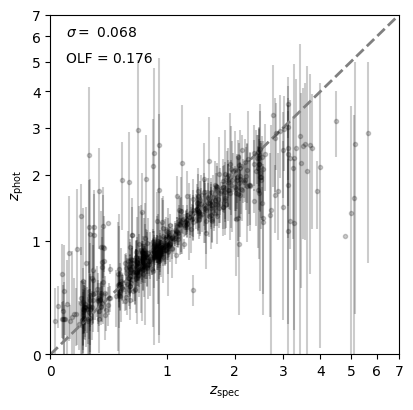

In [26]:
# Function x**(1/2)
def forward(x):
    return np.log10(1+x)

def inverse(x):
    return (10**x) - 1

Fig, Ax = plt.subplots(1,1,figsize=(4.5,4.5))

Ax.errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], 
            fmt='o', ms=3, color='k', ecolor='k', alpha=0.2)
Ax.set_xlim([0, 7])
Ax.set_ylim([0, 7])

Ax.set_yscale('function', functions=(forward, inverse))
Ax.set_xscale('function', functions=(forward, inverse))

stats_simple = calcStats(simple_run['z_spec'], simple_run['value'])

Ax.text(0.1, 6.0, f'$\sigma = $ {stats_simple[0]:.3f}')
Ax.text(0.1, 5.0, f'OLF = {stats_simple[2]:.3f}')

Ax.plot([0, 7], [0, 7], '--', color='0.5', lw=2)
Ax.set_xlabel(r'$z_{\rm{spec}}$')
Ax.set_ylabel(r'$z_{\rm{phot}}$')

In [27]:
test.save('candels_cosmos_save.pkl')

In [28]:
run_from_save = GPz()
run_from_save.load('candels_cosmos_save.pkl')

In [29]:
prediction_cat, _ = run_from_save.predict(cat, 
      outdir=outdir, # Save training/output catalogues in this directory
      basename='candels_cosmos_save', # Start our output filenames with this
      bash_script=False, # Run GPz directly, don't just write the parameter files + commands to bash
      mag_prefix='lupt_', # Look for these asinh magnitude columns
      error_prefix='lupterr_', # Look for these error columns
      id_col='ID', # ID column to propagate into output files
      output_max=9,
      verbose=True,)

setting number of features to 7
begin prediction for 5510 data points
found 7 features
found uncertainties for the features
precomputing cache and applying normalization
missing data cache built (1 combinations found)
starting prediction
will use parallel prediction with chunks of 100 elements
predicted     0/5510 (0%), time remaining: unknown
renormalize output values
total time required for prediction: 1.00709 seconds


In [26]:
run_from_save.predict?

In [30]:
prediction_cat

id,RA,DEC,CLASS_STAR,FLAGS,EBV,z_spec,lupt_U,lupterr_U,lupt_G,lupterr_G,lupt_R,lupterr_R,lupt_I,lupterr_I,lupt_Z,lupterr_Z,lupt_F125W,lupterr_F125W,lupt_F160W,lupterr_F160W,value,uncertainty,var.density,var.tr.noise,var.in.noise
int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
26,150.0605723,2.1755824,0.03,0,0.01906,0.8088,26.8863727528567,0.18879223030806022,25.541056016449954,0.07006021633077232,24.008122067780864,0.035706337039690374,22.730612643371394,0.024630774257137354,22.1717339613438,0.025686615538249934,21.672983479950258,0.009014965523370031,21.286753456895454,0.005550023841152816,0.7983958,0.0935596,0.0001771214,0.007874897,0.0007013801
47,150.0887223,2.1772836,0.1,0,0.01883,2.4167,25.779967330727416,0.08664405311109045,25.074106065984097,0.05472553546653772,24.802762532004582,0.05315612010745353,24.605015542984525,0.05471246138806812,24.414566484394665,0.07420631662000414,24.45351604560323,0.06937576657468801,24.2670248025588,0.04848005061323362,1.796916,0.6867895,0.0009887492,0.4560719,0.01461913
53,150.0830862,2.1778659,0.0,0,0.01889,2.9802,25.62512543190094,0.0791337580023131,24.751997120215634,0.04411023273076501,24.48883388855083,0.043207627212454955,24.411263747444046,0.050968732086869285,24.407634065312745,0.0791865776686459,24.589360958286957,0.05584118788099489,24.383649120930315,0.04170844111142813,2.067094,1.107985,0.001752435,1.207981,0.01789732
62,150.0571343,2.1774997,0.0,0,0.01912,1.049,26.621734083463767,0.16322488351796105,26.238475511770183,0.09652822362146102,25.024856593441502,0.05295130034333675,24.117183420535106,0.04028700682132189,23.428827177428246,0.04283214882802983,22.49179558156003,0.01672284256531877,22.014798121083786,0.009832835623472482,1.127605,0.2537014,0.0006508046,0.06012211,0.003591477
68,150.0702489,2.1781997,0.0,0,0.01902,0.937,25.348788822162014,0.06411054950540862,25.088027261751026,0.049365420916585724,24.639518385385397,0.04384382177006063,23.73429652450963,0.034935196607264296,23.38421051160291,0.04238425397278273,23.001362375523097,0.023148372034470652,22.75179240719723,0.016473454116617107,0.9419915,0.1194939,0.0001571007,0.01263334,0.001488351
105,150.0911919,2.178773,0.0,3,0.0188,0.9715,24.314447879963875,0.05192091301404855,24.267439073771104,0.04501463343907315,24.19436803928077,0.04524357084593745,23.658446081303804,0.04227772621221507,23.469865685789607,0.05856405188220251,23.22266890892724,0.02928424313708088,23.279506814420152,0.02418712624350721,0.9668646,0.09995499,0.0001363228,0.007062052,0.002792624
115,150.0846337,2.1793241,0.02,0,0.0189,0.9779,24.423150042557122,0.04576843957677191,24.168583966479087,0.036538349674057585,23.84414245436666,0.03455427120341351,23.185037032350774,0.030048356382781992,22.958062387999725,0.03802554462642361,22.662873440494582,0.01627072699203523,22.565885709401403,0.012814270180009595,0.8901135,0.08079351,4.802654e-05,0.005387064,0.0010925
122,150.0716064,2.1801353,0.02,0,0.01903,2.3136,26.375500542491025,0.13653612348804642,26.27442393275761,0.10588301822299219,25.996156742670752,0.10023397652756198,25.993101333177986,0.12014645686531725,25.994704479759537,0.22058430442510063,25.742044807270428,0.12306653546166829,25.28687225533138,0.07479031703377992,2.30108,0.872984,0.008092142,0.7416745,0.0123344
123,150.0641591,2.1801106,0.97,0,0.01909,0.043,24.978781083080037,0.06059896610634866,24.274645705421694,0.03865300552279715,23.981854530302765,0.03626474382202585,23.832004184177798,0.04181231425006965,23.765404765835566,0.06042146499133302,24.076736800899422,0.03167248076756447,24.16735843664455,0.028814931901531754,0.900132,0.6823466,0.0009660855,0.4567819,0.007848794
